In [1]:
import tensorflow as tf
from keras.layers import Conv2D, Dense, Flatten, Dropout, AveragePooling2D, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 256
IMG_SIZE = (120, 120)
IMG_HEIGHT, IMG_WIDTH = IMG_SIZE
IMG_NUM = 11730
COLOR_CHANNELS = 3

In [3]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    '../input/recaptcha-image-dump/dataset',
    labels='inferred',
    label_mode='int',
    #class_name=['_'],
    color_mode='rgb',
    batch_size=IMG_NUM,
    image_size=IMG_SIZE,
    shuffle=True
)

Found 11730 files belonging to 1 classes.


2022-08-25 09:13:27.639239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 09:13:27.812464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 09:13:27.816237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 09:13:27.828230: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
X = []
for x, y in ds_train:
    X.append(x)
X = np.array(X).reshape(IMG_NUM, IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS)
X /= 255

2022-08-25 09:13:31.591803: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called..

In [5]:
def discriminator(DROPOUT_RATE):
    model = Sequential([
        AveragePooling2D(4, (2, 2), input_shape=(IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS)),
        Conv2D(128, 3, activation=LeakyReLU(alpha=0.2)),
        Dropout(DROPOUT_RATE),
        Conv2D(64, 3, activation=LeakyReLU(alpha=0.2)),
        Dropout(DROPOUT_RATE),
        Conv2D(32, 3, activation=LeakyReLU(alpha=0.2)),
        Flatten(),
        Dense(128, activation=LeakyReLU(alpha=0.2)),
        Dense(64, activation=LeakyReLU(alpha=0.2)),
        Dense(32, activation=LeakyReLU(alpha=0.2)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [6]:
def generator(n):
    model = Sequential([
        Dense(2**10, activation=LeakyReLU(alpha=0.2)),
        Dense(2**12, activation=LeakyReLU(alpha=0.2)),
        #Dense(2**16, activation=LeakyReLU(alpha=0.2)),
        Dense(IMG_WIDTH*IMG_HEIGHT*COLOR_CHANNELS, activation=LeakyReLU(alpha=0.2)),
        Reshape((IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS))
    ])

    return model

In [7]:
def gan(g, d):
    d.trainable = False
    model = Sequential()
    model.add(g)
    model.add(d)

    model.compile(
        optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [8]:
epochs = 400
batch_size = 512
half_batch = batch_size // 2
n = 100
constant_latent = np.random.randn(n).reshape(n, 1)

In [9]:
g = generator(n)
d = discriminator(0.1)
ganm = gan(g, d)

In [10]:
for i in range(epochs):
    print(f'Epoch{i+1}/{epochs}')
    for j in tqdm(range(len(X) // batch_size)):
        #print(f'Epoch:{i+1}/{epochs}, Batch:{j+1}/{batch_size}')
        xreal = X[np.random.randint(0, len(X), half_batch)].reshape(half_batch, IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS)
        yreal = np.ones(half_batch).reshape(half_batch, 1)
        xfake = g.predict(np.random.randn(half_batch, n))
        yfake = np.zeros(half_batch).reshape(half_batch, 1)

        xfinal = np.vstack([xreal, xfake])
        yfinal = np.vstack([yreal, yfake])

        d.train_on_batch(xfinal, yfinal)
        ganm.train_on_batch(np.random.randn(batch_size, n), np.ones(batch_size).reshape(batch_size, 1))

Epoch1/400


100%|██████████| 22/22 [00:34<00:00,  1.55s/it]


Epoch2/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch3/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch4/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch5/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch6/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch7/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch8/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch9/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch10/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch11/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch12/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch13/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch14/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch15/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch16/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch17/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch18/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch19/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch20/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch21/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch22/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch23/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch24/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch25/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch26/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch27/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch28/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch29/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch30/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch31/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch32/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch33/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch34/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch35/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch36/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch37/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch38/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch39/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch40/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch41/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch42/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch43/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch44/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch45/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch46/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch47/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch48/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch49/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch50/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch51/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch52/400


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch53/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch54/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch55/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch56/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch57/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch58/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch59/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch60/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch61/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch62/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch63/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch64/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch65/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch66/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch67/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch68/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch69/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch70/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch71/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch72/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch73/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch74/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch75/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch76/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch77/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch78/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch79/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch80/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch81/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch82/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch83/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch84/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch85/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch86/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch87/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch88/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch89/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch90/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch91/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch92/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch93/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch94/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch95/400


100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


Epoch96/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch97/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch98/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch99/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch100/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch101/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch102/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch103/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch104/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch105/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch106/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch107/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch108/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch109/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch110/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch111/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch112/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch113/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch114/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch115/400


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch116/400


100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


Epoch117/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch118/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch119/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch120/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch121/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch122/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch123/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch124/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch125/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch126/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch127/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch128/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch129/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch130/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch131/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch132/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch133/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch134/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch135/400


100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


Epoch136/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch137/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch138/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch139/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch140/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch141/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch142/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch143/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch144/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch145/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch146/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch147/400


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


Epoch148/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch149/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch150/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch151/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch152/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch153/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch154/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch155/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch156/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch157/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch158/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch159/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch160/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch161/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch162/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch163/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch164/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch165/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch166/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch167/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch168/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch169/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch170/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch171/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch172/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch173/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch174/400


100%|██████████| 22/22 [00:21<00:00,  1.05it/s]


Epoch175/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch176/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch177/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch178/400


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch179/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch180/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch181/400


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch182/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch183/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch184/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch185/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch186/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch187/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch188/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch189/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch190/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch191/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch192/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch193/400


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


Epoch194/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch195/400


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch196/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch197/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch198/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch199/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch200/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch201/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch202/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch203/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch204/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch205/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch206/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch207/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch208/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch209/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch210/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch211/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch212/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch213/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch214/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch215/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch216/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch217/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch218/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch219/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch220/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch221/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch222/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch223/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch224/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch225/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch226/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch227/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch228/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch229/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch230/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch231/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch232/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch233/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch234/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch235/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch236/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch237/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch238/400


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch239/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch240/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch241/400


100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


Epoch242/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch243/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch244/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch245/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch246/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch247/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch248/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch249/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch250/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch251/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch252/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch253/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch254/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch255/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch256/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch257/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch258/400


100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


Epoch259/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch260/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch261/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch262/400


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


Epoch263/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch264/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch265/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch266/400


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch267/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch268/400


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


Epoch269/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch270/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch271/400


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


Epoch272/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch273/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch274/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch275/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch276/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch277/400


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


Epoch278/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch279/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch280/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch281/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch282/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch283/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch284/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch285/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch286/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch287/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch288/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch289/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch290/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch291/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch292/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch293/400


100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


Epoch294/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch295/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch296/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch297/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch298/400


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch299/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch300/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch301/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch302/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch303/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch304/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch305/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch306/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch307/400


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch308/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch309/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch310/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch311/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch312/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch313/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch314/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch315/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch316/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch317/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch318/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch319/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch320/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch321/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch322/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch323/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch324/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch325/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch326/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch327/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch328/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch329/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch330/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch331/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch332/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch333/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch334/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch335/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch336/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch337/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch338/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch339/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch340/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch341/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch342/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch343/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch344/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch345/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch346/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch347/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch348/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch349/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch350/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch351/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch352/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch353/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch354/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch355/400


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch356/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch357/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch358/400


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch359/400


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch360/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch361/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch362/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch363/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch364/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch365/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch366/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch367/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch368/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch369/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch370/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch371/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch372/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch373/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch374/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch375/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch376/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch377/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch378/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch379/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch380/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch381/400


100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


Epoch382/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch383/400


100%|██████████| 22/22 [00:21<00:00,  1.05it/s]


Epoch384/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch385/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch386/400


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


Epoch387/400


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch388/400


100%|██████████| 22/22 [00:22<00:00,  1.00s/it]


Epoch389/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch390/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch391/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch392/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch393/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch394/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch395/400


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


Epoch396/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch397/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch398/400


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


Epoch399/400


100%|██████████| 22/22 [00:21<00:00,  1.00it/s]


Epoch400/400


100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


In [11]:
g.save('./model.h5')

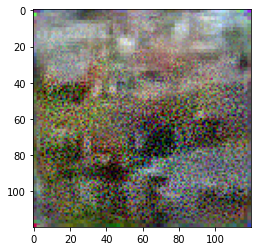

In [12]:
constant_latent = np.random.randn(half_batch, n)
plt.imshow(g.predict(np.random.randn(100).reshape(1, 100)).reshape((IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS)))

plt.show()